<a href="https://colab.research.google.com/github/archie-cm/A-B-Testing-Mobile-Games/blob/main/A_B_Testing_Mobile_Games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction and Context <a name='1'></a>

[Cookie Cats](https://tactilegames.com/cookie-cats/) is a hugely popular mobile puzzle game developed by [Tactile Entertainment](https://tactilegames.com). It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

**As players progress through the game they will encounter gates that force them to wait some time before they can progress or alternatively make an in-app purchase to progress. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention.**

🍪 🐈 🍪 🐈 🍪 🐈

## Problem Statement

Should the proposed gate at Level 40 be implemented over the existing gate at Level 30 based on day 1 and 7 player retention rates.

## Data Descriptions

The dataset contains is from 90,189 players that installed the game while the AB Test was running. 

Dataset labels:
- `userid` - `int` - unique player identifier.
- `version` - `str` - group the player was randomly assigned to: control (`gate_30` .- gate at Level 30) or treatment (`gate_40` - gate at Level 40).
- `sum_gamerounds` - `int` - total number of games played by the player during the first week after installation.
- `retention_1` - `bool` - `True` if the player played 1 day after installing else `False`.
- `retention_7` - `bool` - `True` if the player played 7 days after installing else `False`.

# 2. Imports<a name='2'></a>

In [ ]:
# PyData
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Hypothesis Testing
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
# Global Formatting and rendering
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

# 3. Data <a name='3'></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/cookie_cats.csv')

data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [ ]:
# Check dataframe shape, null counts, datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


### Duplicated Data

In [ ]:
data.duplicated().sum()

0

Tidak terdapat duplicated data

### Missing Data

In [ ]:
data.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

Tidak terdapat missing data

### Dataset Balance

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


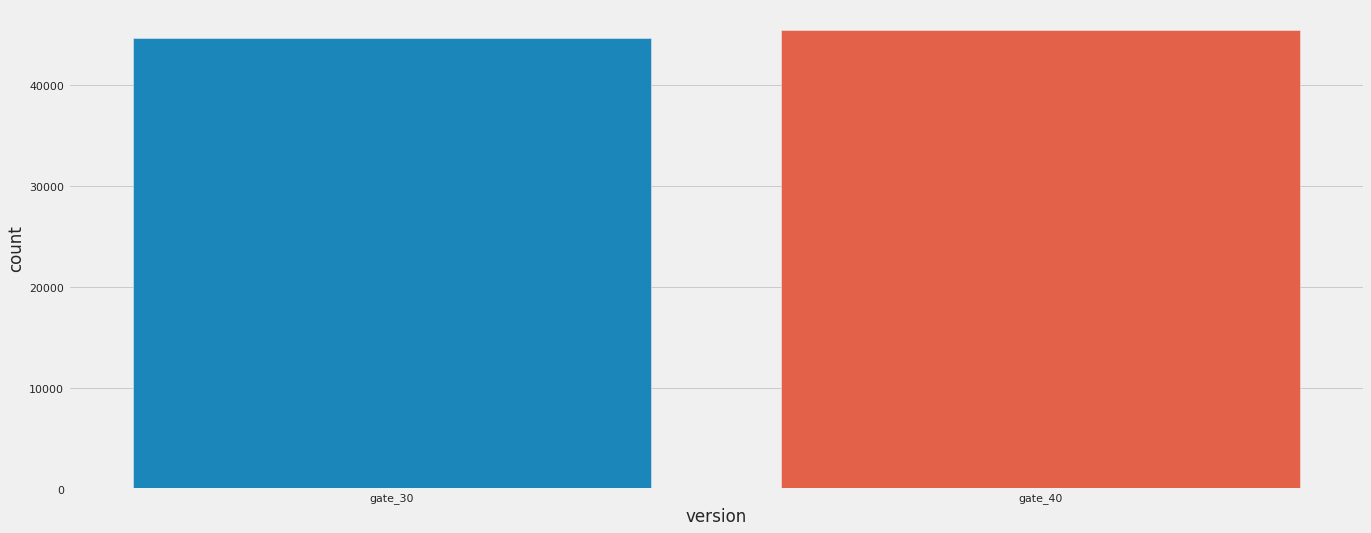

In [ ]:
# Coount of players in control and treatment group w/ visualisation

display(data.groupby('version').count())

sns.countplot(x='version', data=data)
plt.show()

In [ ]:
# Percentage of players in control and treatment groups

control, treatment = data['version'].value_counts()[0], data['version'].value_counts()[1]
print(f'{control / data.shape[0] * 100:.2f}% of users in control group')
print(f'{treatment / data.shape[0] * 100:.2f}% of users in treatment group')

50.44% of users in control group
49.56% of users in treatment group


Spread of randomly assigned players looks even, though Sample Ratio Mismatch (SRM), could still be present. I will not be performing a SRM analysis, but this could be performed with a Chi-squared goodness of fit test.

Observations:
- There are no null values.
- `version`, `retention_1` and `retention_7` have binary values as expected.
- There are no duplicate entries or duplicated users.
- The dataset looks relatively balanced.
- Data is generally clean and ready to use.

# 4. Exploratory Data Analysis <a name='4'></a>

There are two primary explanations that we can perform, the first with the number of game rounds played and the second with the 1 and 7 day retention rates.

## 4.1 EDA - Game Rounds Played <a name ='4.1'></a>

Lets look at the `sum_gamerounds` played for each player, first as a whole of the dataset and then by experiment group.

In [ ]:
# Desptive statistics of the entire data set to get an idea of the distribution

data[['sum_gamerounds']].describe().T

,count,mean,std,min,25%,50%,75%,max
sum_gamerounds,"90,189.00",51.87,195.05,0.00,5.00,16.00,51.00,"49,854.00"


In [ ]:
# Grouped by control and treatment groups

data.groupby('version')['sum_gamerounds'].agg(['count', 'mean', 'median', 'std', 'max'])

,count,mean,median,std,max
version,,,,,
gate_30,44700,52.46,17.00,256.72,49854
gate_40,45489,51.30,16.00,103.29,2640


Looking at the two groups visually, we can see there is an outlier in the `gate_30` group. This will be skewing the data.

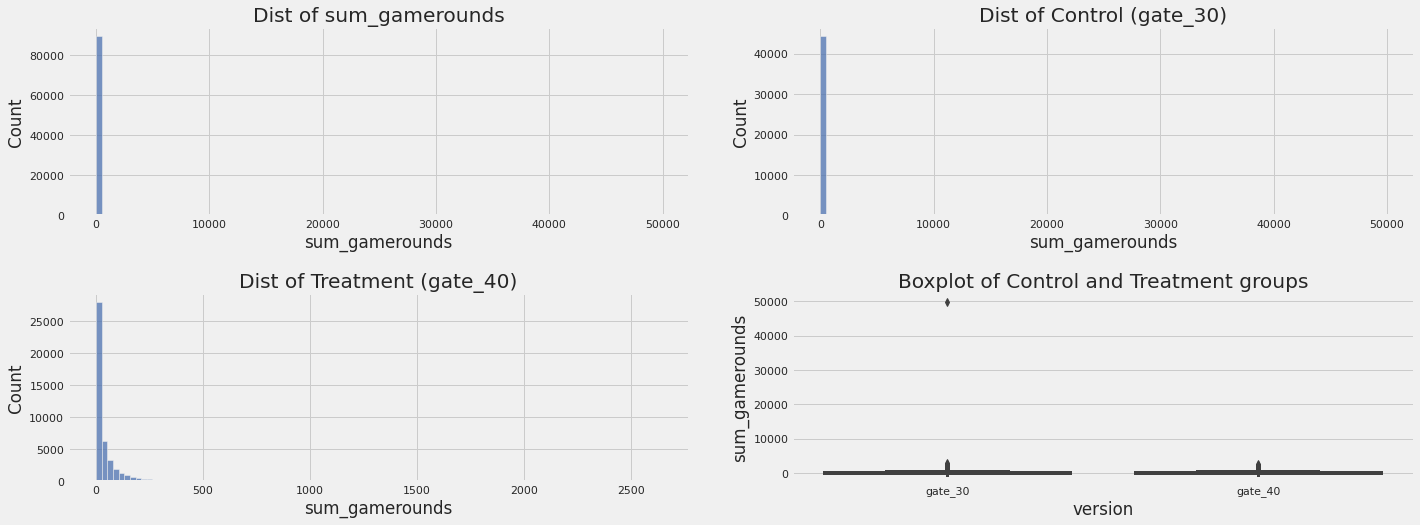

In [ ]:
fig, axes = plt.subplots(2, 2)

sns.histplot(data['sum_gamerounds'], bins=100, ax=axes[0,0])
sns.histplot(data[data['version'] == 'gate_30']['sum_gamerounds'], bins=100, ax=axes[0,1])
sns.histplot(data[data['version'] == 'gate_40']['sum_gamerounds'], bins=100, ax=axes[1,0])
sns.boxplot(x='version', y='sum_gamerounds', data=data, ax=axes[1,1])

axes[0,0].set_title('Dist of sum_gamerounds')
fig.tight_layout(pad=3.0)
axes[0,1].set_title('Dist of Control (gate_30)')
axes[1,0].set_title('Dist of Treatment (gate_40)')
axes[1,1].set_title('Boxplot of Control and Treatment groups')
plt.show()

In [ ]:
# Binning sum_gamerounds into 5 arbitrary size bins to get a feel for how many outliers there are

rounds_bins = pd.cut(data['sum_gamerounds'], 5, labels=[i+1 for i in range(5)])
rounds_bins.value_counts().sort_index()

1    90188
2        0
3        0
4        0
5        1
Name: sum_gamerounds, dtype: int64

This means that if the data was sorted into 5 arbitrary but equal bins by `sum_gamecount`, 90,188 of the values would be in bin one, and one value would be in bin five, with no values in bins two, three, or four. 

The data is telling us that a user played ~50,000 games in the first week after downloading, which if true, is kinda impressive. I am are going to remove the outlier.

In [ ]:
data = data[data['sum_gamerounds'] < data['sum_gamerounds'].max()]

In [ ]:
# Checking descriptive stats of without outlier

display(data.describe().T)
display(data.groupby('version')['sum_gamerounds'].agg(['count', 'mean', 'median', 'std', 'max']))

,count,mean,std,min,25%,50%,75%,max
userid,"90,188.00","4,998,396.80","2,883,297.87",116.00,"2,512,211.25","4,995,804.00","7,496,460.75","9,999,861.00"
sum_gamerounds,"90,188.00",51.32,102.68,0.00,5.00,16.00,51.00,"2,961.00"


,count,mean,median,std,max
version,,,,,
gate_30,44699,51.34,17.00,102.06,2961
gate_40,45489,51.30,16.00,103.29,2640


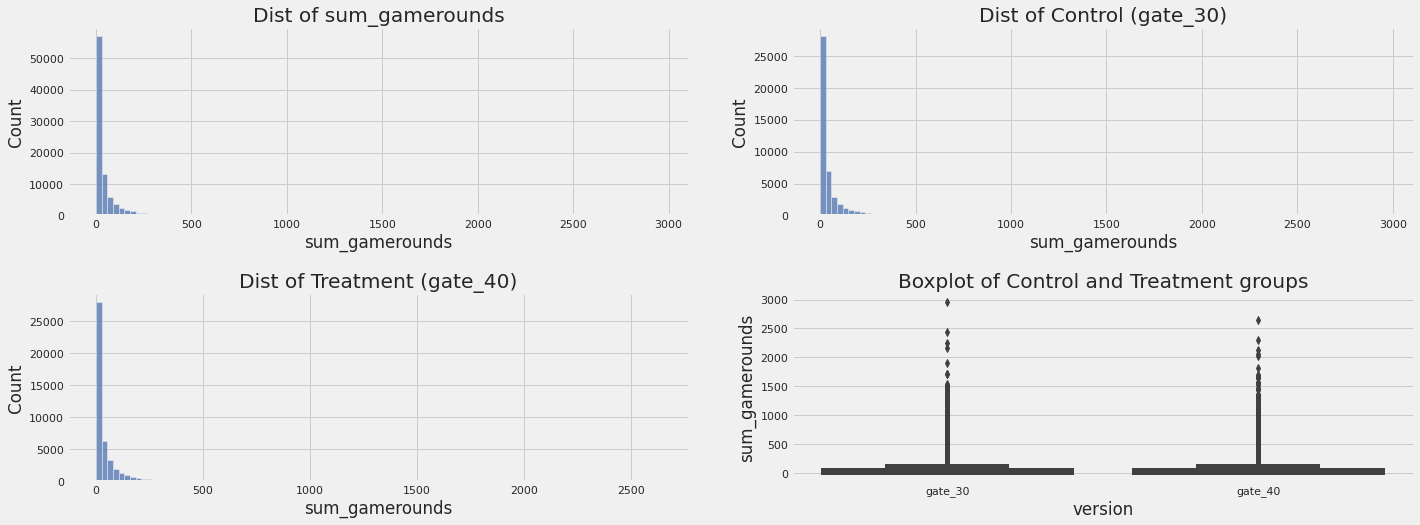

In [ ]:
# Re-plotting without outlier

fig, axes = plt.subplots(2, 2)

sns.histplot(data['sum_gamerounds'], bins=100, ax=axes[0,0])
sns.histplot(data[data['version'] == 'gate_30']['sum_gamerounds'], bins=100, ax=axes[0,1])
sns.histplot(data[data['version'] == 'gate_40']['sum_gamerounds'], bins=100, ax=axes[1,0])
sns.boxplot(x='version', y='sum_gamerounds', data=data, ax=axes[1,1])

axes[0,0].set_title('Dist of sum_gamerounds')
fig.tight_layout(pad=3.0)
axes[0,1].set_title('Dist of Control (gate_30)')
axes[1,0].set_title('Dist of Treatment (gate_40)')
axes[1,1].set_title('Boxplot of Control and Treatment groups')
plt.show()

Boxplots and some stats (mean, std) look more representative of the sample. There is still a skew.

### Univariate - Gamerounds played

Starting with the number of players to reach n rounds and a cumulative sum.

In [ ]:
# Cumulative sum for total sample
def create_gamerounds(df):
    '''Return a dataframe with sum_gamerounds, cound, percent_count, cumsum, percent_cumsum'''
    gamerounds = df.groupby('sum_gamerounds')['userid'].agg(['count']).reset_index()
    gamerounds['percent_count'] = gamerounds['count'] / df.shape[0] * 100
    gamerounds['cumsum'] = gamerounds['count'].cumsum()
    gamerounds['percent_cumsum'] = gamerounds['cumsum'] / df.shape[0] * 100
    return gamerounds
    
gamerounds_tot = create_gamerounds(data)

In [ ]:
gamerounds_tot.head(20)

,sum_gamerounds,count,percent_count,cumsum,percent_cumsum
0,0,3994,4.43,3994,4.43
1,1,5538,6.14,9532,10.57
2,2,4606,5.11,14138,15.68
3,3,3958,4.39,18096,20.06
4,4,3629,4.02,21725,24.09
5,5,2992,3.32,24717,27.41
6,6,2861,3.17,27578,30.58
7,7,2379,2.64,29957,33.22
8,8,2267,2.51,32224,35.73
9,9,2013,2.23,34237,37.96


Looking graphically at the a distribution of all players who played between 0 and 100 game rounds (~86 of the sample)

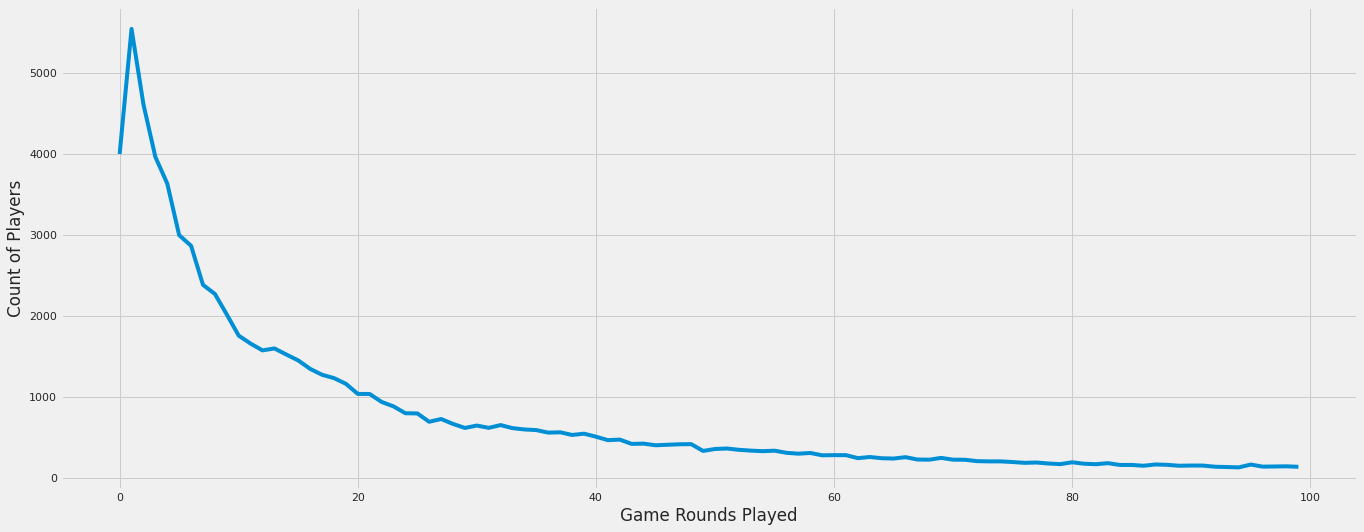

In [ ]:
ax = gamerounds_tot[:100].plot(x='sum_gamerounds', y='count', legend=False)
ax.set_xlabel('Game Rounds Played')
ax.set_ylabel('Count of Players')
plt.show()

### Bivariate - gamerounds played

Insights might be derived from inspecting gamerounds played with respect to group to see if there is an obvious link to retention.

In [ ]:
# Cumulative sum for control and treatment group
gamerounds_cont = create_gamerounds(data[data['version'] == 'gate_30'])
gamerounds_treat = create_gamerounds(data[data['version'] == 'gate_40'])

display(gamerounds_cont.head(20), gamerounds_treat.head(20))

,sum_gamerounds,count,percent_count,cumsum,percent_cumsum
0,0,1937,4.33,1937,4.33
1,1,2749,6.15,4686,10.48
2,2,2198,4.92,6884,15.40
3,3,1899,4.25,8783,19.65
4,4,1831,4.10,10614,23.75
5,5,1442,3.23,12056,26.97
6,6,1420,3.18,13476,30.15
7,7,1199,2.68,14675,32.83
8,8,1162,2.60,15837,35.43
9,9,998,2.23,16835,37.66


,sum_gamerounds,count,percent_count,cumsum,percent_cumsum
0,0,2057,4.52,2057,4.52
1,1,2789,6.13,4846,10.65
2,2,2408,5.29,7254,15.95
3,3,2059,4.53,9313,20.47
4,4,1798,3.95,11111,24.43
5,5,1550,3.41,12661,27.83
6,6,1441,3.17,14102,31.00
7,7,1180,2.59,15282,33.59
8,8,1105,2.43,16387,36.02
9,9,1015,2.23,17402,38.26


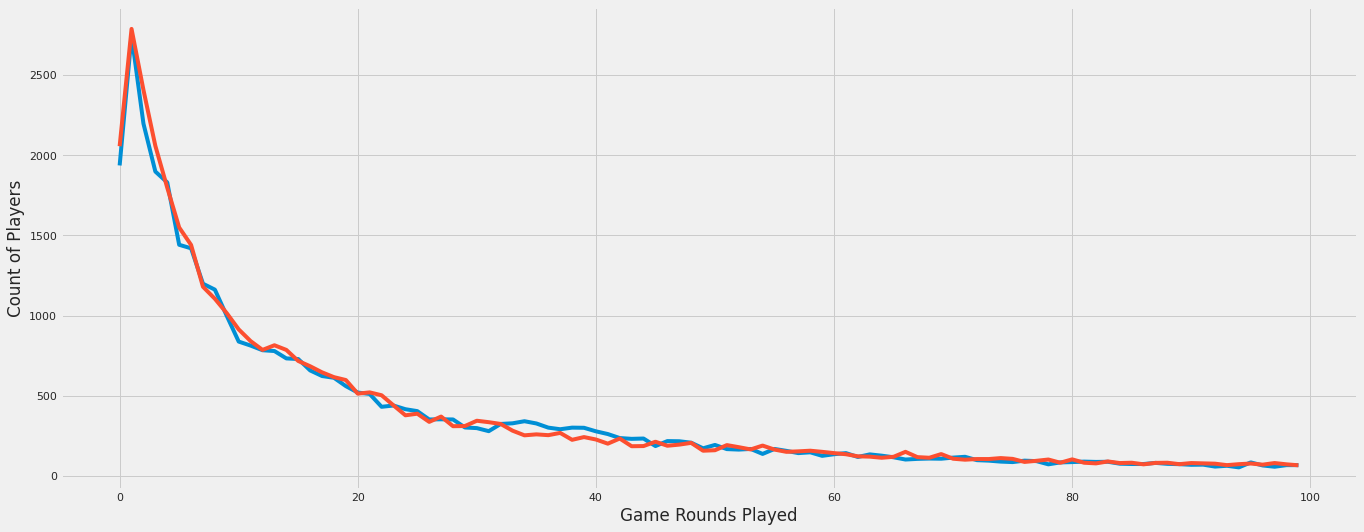

In [ ]:
# Graphically for users who played up to 100 game rounds:

fig, ax = plt.subplots()
sns.lineplot(x='sum_gamerounds', y='count', data=gamerounds_cont[:100], ax=ax)
sns.lineplot(x='sum_gamerounds', y='count', data=gamerounds_treat[:100], ax=ax, palette='Or')
ax.set_xlabel('Game Rounds Played')
ax.set_ylabel('Count of Players')
plt.show()

### Observations on rounds played

All values are with respect to the week after installation. 

There are no obvious links between gamerounds played and the group the player was assigned to.

The number of players decreases as levels increase. The exception is that a number of players installed the game and did not complete any levels (installed and did not play).
- 3,994 (~4.4%) players did not play the game
- ~27.4% of players played five or less rounds
- 50% of players played 16 or less rounds
- 75% of players played less than 50 rounds

These values can be explored by themselves, especially the 3,994 players installing the game and not playing in the week following installation, in addition over a quarter of players in the sample played 5 rounds or less in the week following installation. Possible reasons may include but aren't limited to:
- Players didn't like the game or aspect of the game (mechanics/aesthetics/music/story?).
- Difficulty increased as levels progressed and locked players out.
- Don't like the free-mium model.
- Product was not as advertised.
- Players haven't had an opportunity to play the game.

With churn happening at relatively low number of rounds played, there is an opportunity to increase retention. Fact finding (exit surveys) and incentives could lead to higher retention rates. More research is required.

In [ ]:
(0.448 * (1 - 0.448) + 0.442 * (1 - 0.442)) * ((1.96 / 0.05) ** 2)

758.9956684799998

## 4.2 EDA - Retention <a name ='4.2'></a>

In [ ]:
# Looking at all players

pd.DataFrame({'retention_1_count': data['retention_1'].value_counts(),
             'retention_1_perc': data['retention_1'].value_counts() / data.shape[0],
             'retention_7_count': data['retention_7'].value_counts(),
             'retention_7_perc': data['retention_7'].value_counts() / data.shape[0]}).reset_index()

,index,retention_1_count,retention_1_perc,retention_7_count,retention_7_perc
0,False,50035,0.55,73408,0.81
1,True,40153,0.45,16780,0.19


In [ ]:
# 1 Day Retention by group

reten_1 = data.groupby(['version', 'retention_1'])['sum_gamerounds'].agg(['mean', 'median', 'std', 'max', 'count'])
reten_1['ratio'] = reten_1.groupby(level=0).apply(lambda x: x / x.sum())['count']
reten_1

mean  median    std   max  count  ratio
version retention_1                                         
gate_30 False       16.36    6.00  36.53  1072  24665   0.55
        True        94.41   48.00 135.04  2961  20034   0.45
gate_40 False       16.34    6.00  35.93  1241  25370   0.56
        True        95.38   49.00 137.89  2640  20119   0.44

In [ ]:
# 7 Day Retention by group

reten_7 = data.groupby(['version', 'retention_7'])['sum_gamerounds'].agg(['mean', 'median', 'std', 'max', 'count'])
reten_7['ratio'] = reten_7.groupby(level=0).apply(lambda x: x / x.sum())['count']
reten_7

mean  median    std   max  count  ratio
version retention_7                                          
gate_30 False        25.80   11.00  43.32   981  36198   0.81
        True        160.12  105.00 179.36  2961   8501   0.19
gate_40 False        25.86   11.00  44.41  2640  37210   0.82
        True        165.65  111.00 183.79  2294   8279   0.18

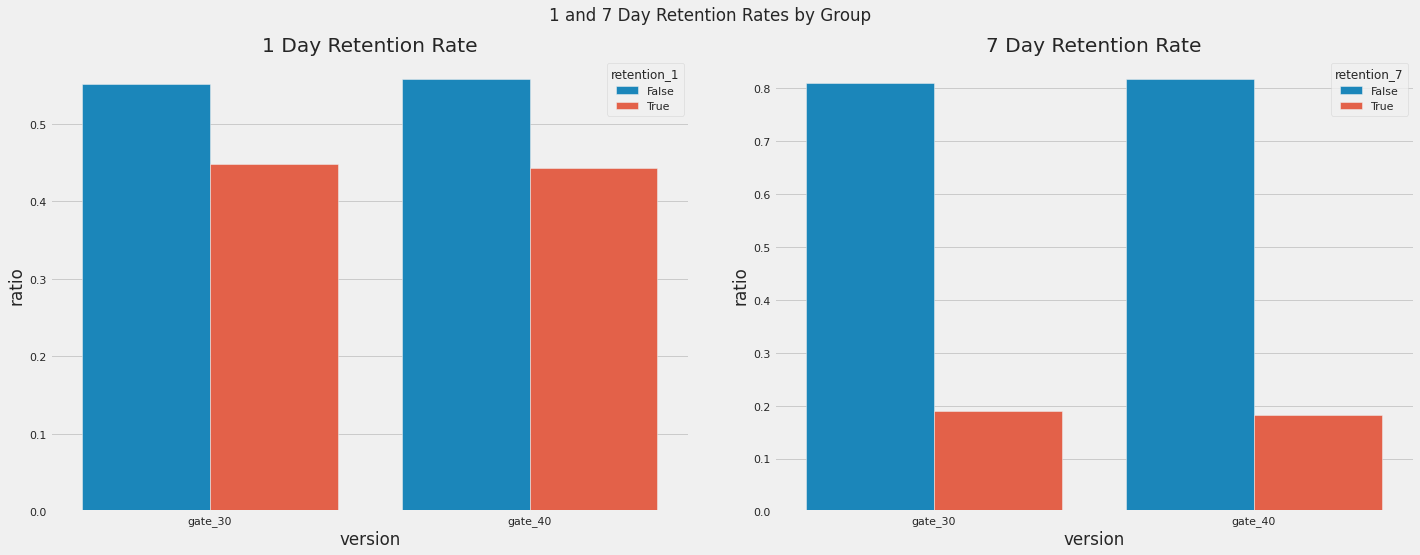

In [ ]:
# 1 and 7 day by treatment group graphically

fig, axes = plt.subplots(1, 2)
sns.barplot(x='version', y='ratio', data=reten_1.reset_index(), hue='retention_1', ax=axes[0])
sns.barplot(x='version', y='ratio', data=reten_7.reset_index(), hue='retention_7', ax=axes[1])

plt.suptitle('1 and 7 Day Retention Rates by Group')
fig.tight_layout(pad=3.0)
axes[0].set_title('1 Day Retention Rate')
fig.tight_layout(pad=3.0)
axes[1].set_title('7 Day Retention Rate')
plt.show()

In [ ]:
# Looking at both day 1 and 7 values together

reten_both = data.groupby(['version', 'retention_1', 'retention_7'])['sum_gamerounds'].agg(['mean', 'median', 'std', 'max', 'count'])
reten_both['ratio'] = reten_both.groupby(level=0).apply(lambda x: x / x.sum())['count']
reten_both

mean  median    std   max  count  ratio
version retention_1 retention_7                                          
gate_30 False       False        11.82    6.00  21.64   981  22840   0.51
                    True         73.17   43.00  93.22  1072   1825   0.04
        True        False        49.69   33.00  58.13   918  13358   0.30
                    True        183.89  127.00 189.63  2961   6676   0.15
gate_40 False       False        11.91    6.00  20.90   547  23597   0.52
                    True         75.26   47.00  94.48  1241   1773   0.04
        True        False        50.03   32.00  60.92  2640  13613   0.30
                    True        190.28  133.00 194.22  2294   6506   0.14

In [ ]:
# Add a column with 1 and 7 Day Retention Bools
reten_both['retention_1_str'] = np.where(reten_both.reset_index()['retention_1'] == True, 'True', 'False')
reten_both['retention_7_str'] = np.where(reten_both.reset_index()['retention_7'] == True, 'True', 'False')
reten_both['reten_both'] = reten_both['retention_1_str'].str.cat(reten_both['retention_7_str'], '-')
reten_both.drop(columns=['retention_1_str', 'retention_7_str'], inplace=True)
# test['reten_both'] = test['retention_1'].apply(lambda x, y: f"{str(x)}+{str(y)}", test['retention_7'], axis=1)
reten_both

mean  median    std   max  count  ratio  \
version retention_1 retention_7                                             
gate_30 False       False        11.82    6.00  21.64   981  22840   0.51   
                    True         73.17   43.00  93.22  1072   1825   0.04   
        True        False        49.69   33.00  58.13   918  13358   0.30   
                    True        183.89  127.00 189.63  2961   6676   0.15   
gate_40 False       False        11.91    6.00  20.90   547  23597   0.52   
                    True         75.26   47.00  94.48  1241   1773   0.04   
        True        False        50.03   32.00  60.92  2640  13613   0.30   
                    True        190.28  133.00 194.22  2294   6506   0.14   

                                  reten_both  
version retention_1 retention_7               
gate_30 False       False        False-False  
                    True          False-True  
        True        False         True-False  
                    True           True-True  
gate_40 False       False        False-False  
                    True          False-True  
        True        False         True-False  
                    True           True-True

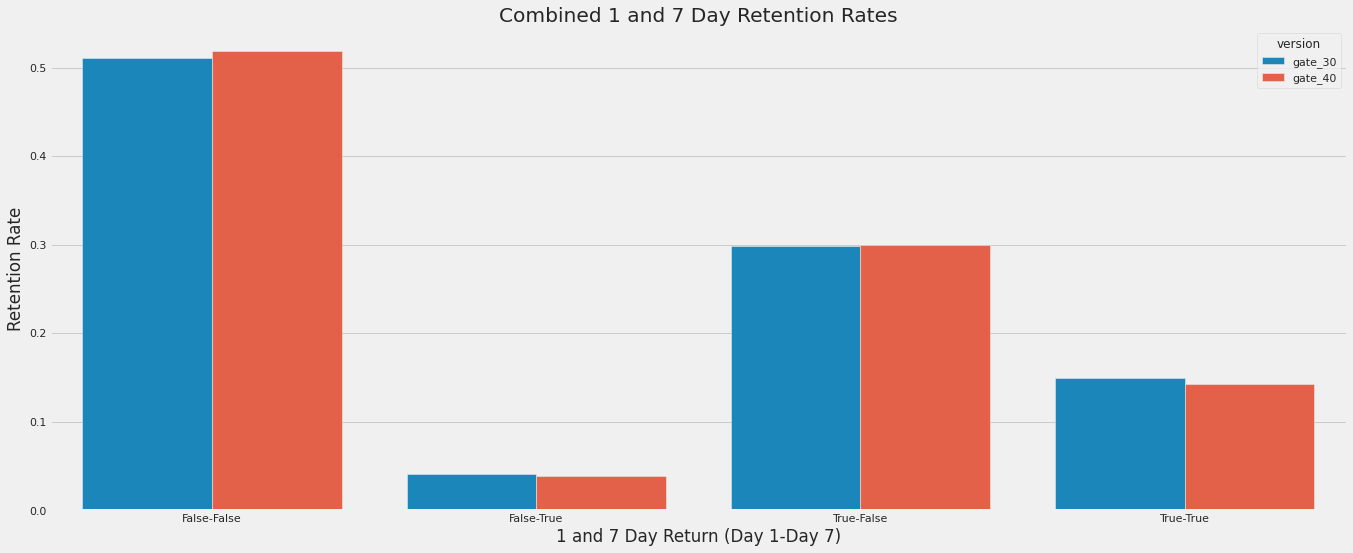

In [ ]:
# Looking at combined 1 and 7 Day Retention Rates

fig, ax = plt.subplots()
sns.barplot(x='reten_both', y='ratio', data=reten_both.reset_index(), hue='version', ax=ax)
ax.set_title('Combined 1 and 7 Day Retention Rates')
ax.set_xlabel('1 and 7 Day Return (Day 1-Day 7)')
ax.set_ylabel('Retention Rate')

plt.show()

### Retention Rate Observations

Considering the entire sample, the 1 and 7 Day Retention Rate are 0.445 and 0.186 respectively. 

Graphically, there is not much to see. **The values for Day 1 and Day 7 retention rates are slightly higher for the control group,  `gate_30`, with a 1 and 7 Day retention rate of 0.448 and 0.190 respectively, compared with the the treatment group, `gate_40`, rates of 0.442 and 0.182.** The control groups retention rates are greater than the retention rates for the entire sample.

AB tests will be performed to see if these values are statistically significant or not.

Looking at the combined 1 and 7 Day Retention Rates, it looks like slightly more players assigned to the control group, `gate_30`, played the game both on Day 1 and with 7 Days (True-True), and more players assigned to the treatment group, `gate_40`, played neither on Day 1 or Day 7 (False-False) 

# 5. AB Tests <a name ='5'></a>

The business question relates specifically to changing the gates based on the day 1 and 7 retention rates. We can also perform an A/B test on sum_gamerounds to check if there is a statistically significant difference in the number of gamerounds played based on assigned group.

Therefore, A/B tests on three separate targets: `retention_1`, `retention_7`, and `sum_gamerounds`



A confidence interval of 95% will be taken for all tests.

## 5.1. Day 1 Retention <a name ='5.1'></a>

### 5.1.1. Bootstrapping <a name ='5.1.1'></a>

We will perform a bootstrap analysis. Bootstrapping consists of repeatedly resampling the dataset with replacement with respect to each experimental group. This will provide a normal sampling distribution for both experiment groups. The variation between in Day 1 Retention rates played provides an indication of uncertainty between the two sampling distributions.

In [ ]:
# Arbitrarily using 1000 random samples with replacement
boot_1d = []

for i in range(1000): # Reduce to reduce notebook run-time
    boot_1d.append(data.sample(frac=1, replace=True).groupby('version')['retention_1'].mean())
    
boot_1d = pd.DataFrame(boot_1d).reset_index().drop(columns=['index'])
boot_1d.head()

version,gate_30,gate_40
0,0.45,0.44
1,0.44,0.44
2,0.44,0.45
3,0.45,0.44
4,0.45,0.44


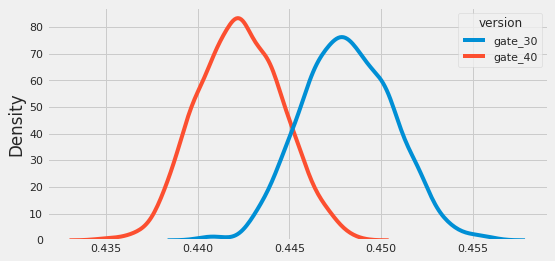

In [ ]:
# Plotting distributions of the two experimental groups
fig, ax = plt.subplots(figsize=(8,4))
sns.kdeplot(data=boot_1d, ax=ax)
plt.show()

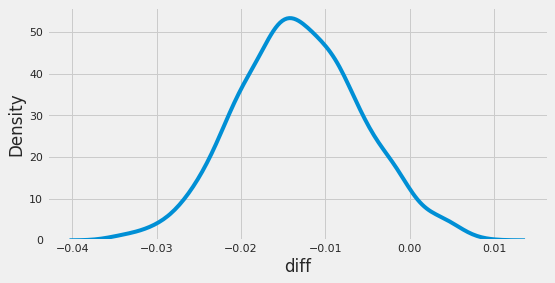

In [ ]:
# Percentage difference between gate_30 and gate_40, this will provide a distribution relative to zero
boot_1d['diff'] = (boot_1d['gate_40'] - boot_1d['gate_30']) / boot_1d['gate_30']

# Plotting 
fig, ax = plt.subplots(figsize=(8,4))
sns.kdeplot(data=boot_1d['diff'], ax=ax)
plt.show()

In [ ]:
# Probability that 1 Day Retention is greater when gate is at Level 40
prob = (boot_1d['diff'] > 0).mean()
prob

0.037

By plotting the difference between the two bootstrapped distributions and taking the percentage difference, we can determine the probability that the 1 Day retention rate was greater when the gate was set to 40. The probability calculated was 0.021 or 2.1%, suggesting that retention was greater when the gate was set to Level 30.

## 5.1.2. Proportional z-test <a name ='5.1.2'></a>

Because we are testing *retention rates*, a 2 sample proportional z-test is appropriate to check the proportions between the control and treatment group are statistically significant. The retention rate for `gate_40` can either go above or below the existing `gate_30`, requiring a two-tailed z-test. 

H0 = The proportions are the same

H1 = The proportions are different

In [ ]:
# Significance Level
alpha = 0.025

cont_succ = data[data['version'] == 'gate_30']['retention_1'].sum()
cont_size = data[data['version'] == 'gate_30'].shape[0]
treat_succ = data[data['version'] == 'gate_40']['retention_1'].sum()
treat_size = data[data['version'] == 'gate_40'].shape[0]

(cont_succ, cont_size), (treat_succ, treat_size)

((20034, 44699), (20119, 45489))

In [ ]:
z_score, p_value = proportions_ztest(count=[cont_succ, treat_succ], nobs=[cont_size, treat_size], alternative='two-sided')

z_score, p_value

(1.787103509763628, 0.0739207603418346)

The z-test provided a *p-value* greater than 0.025, meaning we **can not reject the Null Hypothesis** of the the proportions being the same.

### 5.2. Day 7 Retention <a name ='5.2'></a>

Analysis is the same as Day 1 Retention.

### 5.2.1. Bootstrapping <a name ='5.2.1'></a>

In [ ]:
# Arbitrarily using 1000 random samples with replacement
boot_7d = []

for i in range(1000): # Reduce to reduce notebook run-time
    boot_7d.append(data.sample(frac=1, replace=True).groupby('version')['retention_7'].mean())
    
boot_7d = pd.DataFrame(boot_7d).reset_index().drop(columns=['index'])
boot_7d.head()

version,gate_30,gate_40
0,0.19,0.18
1,0.19,0.18
2,0.19,0.18
3,0.19,0.18
4,0.19,0.18


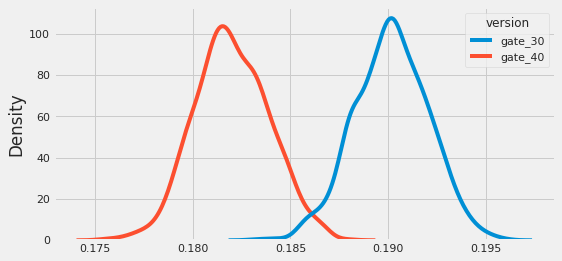

In [ ]:
# Plotting distributions of the two experimental groups
fig, ax = plt.subplots(figsize=(8,4))
sns.kdeplot(data=boot_7d, ax=ax)
plt.show()

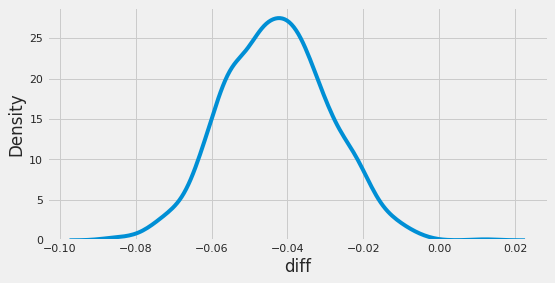

In [ ]:
# Percentage difference between gate_30 and gate_40, this will provide a distribution relative to zero
boot_7d['diff'] = (boot_7d['gate_40'] - boot_7d['gate_30']) / boot_7d['gate_30']

# Plotting 
fig, ax = plt.subplots(figsize=(8,4))
sns.kdeplot(data=boot_7d['diff'], ax=ax)
plt.show()

In [ ]:
# Probability that 1 Day Retention is greater when gate is at Level 40
prob = (boot_7d['diff'] > 0).mean()
prob

0.001

By plotting the difference between the two bootstrapped distributions and taking the percentage difference, we can determine the probability that the 7 Day retention rate was greater when the gate was set to 40. The probability calculated was 0.001 or 0.1%, suggesting that retention was greater when the gate was set to Level 30.

### 5.2.2. Proportional z-test <a name ='5.2.2'></a>

H0 = The proportions are the same

H1 = The proportions are different

In [ ]:
# Significance Level
alpha = 0.025

cont_succ = data[data['version'] == 'gate_30']['retention_7'].sum()
cont_size = data[data['version'] == 'gate_30'].shape[0]
treat_succ = data[data['version'] == 'gate_40']['retention_7'].sum()
treat_size = data[data['version'] == 'gate_40'].shape[0]

(cont_succ, cont_size), (treat_succ, treat_size)

((8501, 44699), (8279, 45489))

In [ ]:
z_score, p_value = proportions_ztest(count=[cont_succ, treat_succ], nobs=[cont_size, treat_size], alternative='larger')

z_score, p_value

(3.1574100858819936, 0.0007958865886996721)

The z-test provided a *p-value* **less** than 0.025, meaning we can reject the Null Hypothesis. This indicates the proportions between the two distributions are statistically significantly different. Because this is a bi-directional test, **this would suggest that `gate_40` is worse for 7 Day Retention than `gate_30`.**  

## 5.3. Game Rounds <a name ='5.3'></a>

The AB test was based on the Day 1 and 7 retention. This is a statistical analysis on gamerounds just for fun.

## 5.3.1. Bootstrapping <a name ='5.3.1'></a>

In [ ]:
# Arbitrarily using 1000 random samples with replacement
sum_gamerounds = []

for i in range(1000): # Reduce to reduce notebook run-time
    sum_gamerounds.append(data.sample(frac=1, replace=True).groupby('version')['sum_gamerounds'].mean())
    
sum_gamerounds = pd.DataFrame(sum_gamerounds).reset_index().drop(columns=['index'])
sum_gamerounds.head()

version,gate_30,gate_40
0,51.10,50.93
1,51.38,51.68
2,51.46,50.83
3,51.95,51.93
4,51.31,51.07


The two bootstrapped distributions provide uncertainty over the underlying sum gamerounds played could be for each experimental group, control and treatment.

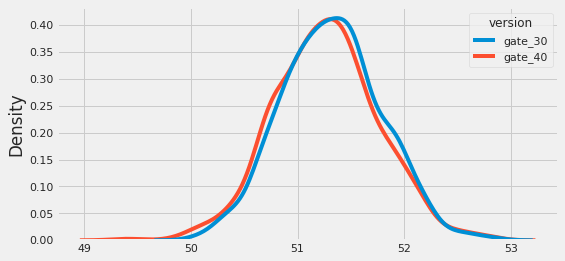

In [ ]:
# Plotting distributions of the two experimental groups
fig, ax = plt.subplots(figsize=(8,4))
sns.kdeplot(data=sum_gamerounds, ax=ax)
plt.show()

The two distributions are overlapped, will not gain any useful insights. Looking closer at the differece between the distributions.

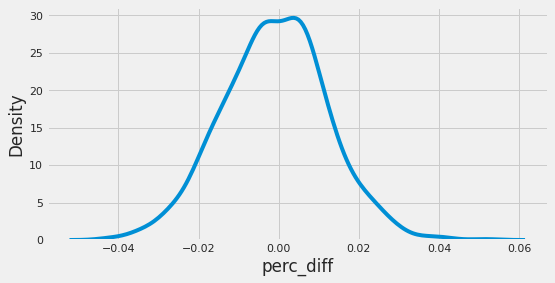

In [ ]:
# Percentage difference between gate_30 and gate_40
sum_gamerounds['perc_diff'] = (sum_gamerounds['gate_40'] - sum_gamerounds['gate_30']) / sum_gamerounds['gate_30']

# Plotting 
fig, ax = plt.subplots(figsize=(8,4))
sns.kdeplot(data=sum_gamerounds['perc_diff'], ax=ax)
plt.show()

In [ ]:
# Calculating the probability players will complete more gamerounds is greater when the gate is set at Level 40
prob = (sum_gamerounds['perc_diff'] > 0).mean()
prob

0.476

The probability that 1 Day Retention is greater when the gate is set at Level 40 is 0.481, slightly worse than a coin flip.

### 5.3.2. Mann-Whitney U test <a name ='5.3.2'></a>

The distribution of gamerounds played is clearly not normally distributed, but we can perform a Shapiro-Wilks test to confirm.

In [ ]:
# Testing the normalcy of sum_gamerounds
# H0 = sample is from a normal distribution (p-value > 0.05)
# H1 = sample is not from a normal distribution (p-value < 0.05)

control = data[data['version'] == 'gate_30']
treatment = data[data['version'] == 'gate_40']

# Checking control and treatment frames have been split correctly
control['version'].nunique(), treatment['version'].nunique()

(1, 1)

In [ ]:
shap_cont = stats.shapiro(control['sum_gamerounds'])
shap_treat = stats.shapiro(treatment['sum_gamerounds'])

In [ ]:
shap_cont[1], shap_treat[1]

(0.0, 0.0)

The p-values for the Shapiro-Wilks test are non-trivially small, there is sufficient evidence to accept the hypothesis that the sample is not from a normal distribution.

Applying Mann-Whitney U test:

In [ ]:
_, p_value = stats.mannwhitneyu(control['sum_gamerounds'], treatment['sum_gamerounds'])
print(f'The p-value of the Mann Whitney U test is {p_value:.4f}.')

The p-value of the Mann Whitney U test is 0.0509.


Because the p-value of the Mann Whitney U test, 0.0509, is greater than 0.05, the null hypothesis can not be rejected. That is to say, **there is insufficient evidence that increasing the gate to Level 40 will increase the sum of gamerounds played by users.**

Statistically analysing the total gamerounds played has not provided much insight.

# 6. Conclusion <a name ='6'></a>

In this an analysis, an exploratory data analysis was performed on the gamerounds completed by each user and the Day 1 and 7 Retention rates. The data was clean with the exception of a single disproportionate outlier that was corrected for. A/B Testing using bootstrap analysis and proportional z-tests was done on Day 1 and 7 Retention rates, and bootstrap analysis and Mann-Whitney U test on gamerounds played. 

Based on the results of the z-test, **there is strong evidence that Day 7 retention rates are higher when the gate is at  Level 30.** Therefore, the gate should not be moved.
The bootstrap analysis suggests that the Level 30 gate is better for Day 1 Retention. Further investigation is required.

Looking at the cumulative number of games played per person, there where no statistically significant results. Rounds played could be examined further, for example to see if there is any impact on in-app micro transactions.

---